# Project Navigation Guidelines

In [1]:
'''
===================================================
Notebook naming convention for FindMeInside (FMI)
===================================================
Notebook name: [FMI] <Coord/Label> Alg - Exp<experiment_number>, Trial<trial_number>

===================================================
Folder/File naming convention
===================================================
# Folder categorised by Experiment (except Testing folder)
Folder name: Experiment<Experiment_number>

# Each Folder has N files.
# A file is either a 1)Unprocessed Dataset, 2)Processed Dataset, 3)Results dataset, 4) Notebook file
# Each experiment has N trials. (Adjustments to parameters/algorithm are made in each trial)
Files in folder will be named accordingly...

- Raw data point:             E<experiment_number>_Label/Location<location_identifier>_<date>v<version_number>
-- e.g. E1_LabelA_230320v1
- Raw data collection:        E<experiment_number>_All_Raw_<date>v<version_number>
-- e.g. E1_All_Raw_230320v1
- Processed data (if any):    E<experiment_number>_All_Proc_<date>v<version_number>
-- e.g. E1_All_Proc_230320v1
- Resampled data (if any):    E<experiment_number>_resampled_t<trial_number>
-- e.g. E1_resampled_t1
- Results data:               E<experiment_number>_<algorithm>_t<trial_number>_k<number_of_neighbours>
-- e.g. E1_KNN_t1_k37

===================================================
List of experiment(s) & description(s)
===================================================
>> Experiment 1 (Exp1) :11 Sensors {1, ..., 11} , 4 Location Labels {A,B,C,D}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 2 (Exp2) :11 Sensors {1, ..., 11} , 4 Location Coords {(x_A, y_A), ... (x_D, y_D)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 3 (Exp3) : 12 Sensors {0x1, ..., 0xC} , 12 Location Label {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 4 (Exp4) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 5 (Exp5) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 6 (Exp6) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Resampled 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 7 (Exp7) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via FindMeInside Phone App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

'''
None

# Trial Description

In [6]:
exp = 6
trial = 1
'''
Trial 1
Algorithms use calcLocation mechanic
Resampling done within time period of 2s.
'''
None

# Core Libraries

In [7]:
import pandas as pd #from pandas import read_csv, pivot_table
import numpy as np
import math
import operator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# [Exploratory Data Analysis]

# Prepare/Load Relevant Dataset

In [8]:
# Read csv file into dataframe.
csvfile = pd.read_csv('E6_All_Proc_230320v1.csv')
relDf = pd.DataFrame(csvfile)
# print(relDf)
relDf.columns = relDf.columns.str.strip() #strip unintended whitespaces

# print("Columns: ", relDf.columns)
relDf = relDf[['Date','Time', 'ID2', 'RSSI', 'Location']] #select relevant columns
# df = df.drop(columns=['Type', 'ID0', 'ID1', 'Sensor Data', 'Temperature', 'Humidity', 'Raw Data'])
print(relDf)

          Date       Time      ID2  RSSI Location
0      16/3/20   15:14:49   0x0001   192      1,1
1      16/3/20   15:14:49   0x0003   177      1,1
2      16/3/20   15:14:49   0x0004   179      1,1
3      16/3/20   15:14:50   0x0002   189      1,1
4      16/3/20   15:14:51   0x0008   177      1,1
...        ...        ...      ...   ...      ...
52882  19/3/20   15:48:51   0x0009   177    19,13
52883  19/3/20   15:48:51   0x0004   177    19,13
52884  19/3/20   15:48:51   0x0002   177    19,13
52885  19/3/20   15:48:51   0x000B   189    19,13
52886  19/3/20   15:48:51   0x0005   177    19,13

[52887 rows x 5 columns]


# Resample/Reshape Dataset

In [9]:
# Preparation for Date/Time Differences
# ----------------------------------------

# Combine date and time to datetime
readings = relDf.copy()
readings['Datetime'] = pd.to_datetime(readings['Date'].apply(str)+' '+readings['Time']) #create new Datetime field
dateTime = readings['Datetime']
readings = readings.drop(columns=['Datetime'])
readings.insert(0, 'Datetime', dateTime)
readings = readings.drop(columns=['Date','Time'])
readings.tail()

from datetime import datetime as dt
earliestDate = readings.Datetime.dt.date.min()
print(readings.Datetime.dt.date.iloc[-1])
print(earliestDate - readings.Datetime.dt.date.iloc[-1])

# Function that expresses timestamps in seconds.
def time_to_sec(timeArray):
    timeSecArray = []
    for i in range(len(timeArray)):
        seconds = (timeArray[i].hour * 60 + timeArray[i].minute) * 60 + timeArray[i].second
        timeSecArray.append(seconds)
    return(timeSecArray)

# Function that calculates day difference between dates in seconds
def date_to_sec(dateArray):
    dateSecArray = []
    for i in range(len(dateArray)):
        dayDiff = dateArray[i] - earliestDate
        dateSecArray.append(dayDiff.total_seconds())
#     print(i)
    return(dateSecArray)


readings['DateSec'] = date_to_sec(readings.Datetime.dt.date)
readings['TimeSec'] = time_to_sec(readings.Datetime.dt.time)
readings['DatetimeSec'] = readings['DateSec'] + readings['TimeSec']
readings = readings[['DatetimeSec', 'ID2', 'RSSI', 'Location']]

# pd.set_option('display.max_columns', 10)
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.width', 500)

readings.DatetimeSec = (readings.DatetimeSec - readings.DatetimeSec.min()) // 2
time_diff_btw_rows = readings.DatetimeSec.diff().fillna(0)
# print(time_diff_btw_rows)
time_diff_btw_rows -= (time_diff_btw_rows > 1) & (readings.DatetimeSec % 2 > 0)
readings.DatetimeSec -= (time_diff_btw_rows - 1).clip(lower=0).cumsum()
readings.ID2 = readings.ID2.transform(lambda hexadecimal: int(hexadecimal, 16))
resampled_readings = readings.groupby(["DatetimeSec", "Location", "ID2"]).mean().reset_index()
pivoted_readings = pd.pivot_table(resampled_readings, values="RSSI", columns=["ID2"], index=["DatetimeSec", "Location"]).fillna(0)

writeFile = True
if (writeFile == True):
    pivoted_readings.to_csv('E6_resampled_T1.csv')
    print("FILE WRITTEN")

pivoted_readings.head()

2020-03-19
-3 days, 0:00:00
FILE WRITTEN


,ID2,1,2,3,4,5,6,7,8,9,10,11,12
DatetimeSec,Location,,,,,,,,,,,,
0.0,"1,1",192.0,189.0,177.0,179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,"1,1",193.0,182.0,180.0,0.0,177.0,0.0,0.0,177.0,177.0,0.0,177.0,0.0
2.0,"1,1",191.0,191.0,185.0,184.0,177.0,177.0,0.0,177.0,0.0,177.0,0.0,177.0
3.0,"1,1",195.0,192.0,184.0,182.0,177.0,177.0,177.0,177.0,0.0,0.0,177.0,177.0
4.0,"1,1",194.0,193.0,184.0,187.0,0.0,0.0,177.0,178.0,0.0,0.0,0.0,177.0


In [10]:
resampledDS = pd.read_csv('E6_resampled_T1.csv')
tempSeries = resampledDS['Location']
resampledDS = resampledDS.drop(columns=['Location', 'DatetimeSec'])
resampledDS["Location"] = tempSeries
resampledDS.head()
lastIndex = len(resampledDS)
numCol = len(resampledDS.columns)

ips_data = resampledDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_label = resampledDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)

X_test = ips_data.to_numpy()
y_test = ips_label.to_numpy()
print(len(y_test))
y_test

5650


array([['1,1'],
       ['1,1'],
       ['1,1'],
       ...,
       ['19,13'],
       ['19,13'],
       ['19,13']], dtype=object)

# Load Test Set

In [11]:
trainsetDS = pd.read_csv('E5copy_resampledavg_T1.csv')
tempSeries = trainsetDS['Location']
trainsetDS = trainsetDS.drop(columns=['Location'])
trainsetDS["Location"] = tempSeries
trainsetDS.head()

ips_data2 = trainsetDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_label2 = trainsetDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)

X_train = ips_data2.to_numpy()
y_train = ips_label2.to_numpy()
y_train = y_train.reshape(len(y_train),)
print(len(y_train))
y_train

k_value_rootN = math.ceil(math.sqrt(len(X_train)))
print("estimated k value: ", k_value_rootN)
# print("X_test: ", X_test)
# print("y_test: ", y_test)

12
estimated k value:  4


# Parameter Optimisation

# KNN Algorithm - Distance Calculation

In [12]:
#Function calculates euclidean distance between two n-dimensional data instances 
def euclideanDistance(instance1, instance2):
    #handles if instances are lists or tuples:
    instance1 = np.array(instance1) 
    instance2 = np.array(instance2)
    
    '''
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html
    uses 2-norm frobenius norm and returns euclidean distance
    '''
    return np.linalg.norm(instance1 - instance2) #euclidean distance

# KNN Algorithm - Determining Neighbours

In [13]:
#Function finds nearest neighbours; nearest -> smallest euclidean distance
def get_neighbors(training_set, 
                  labels, 
                  test_instance, 
                  k, 
                  distance=euclideanDistance):
    """
    get_neighbors calculates a list of the k nearest neighbors
    of an instance 'test_instance'.
    The list neighbors contains 3-tuples with  
    (index, dist, label)
    where
    index    is the index from the training_set, 
    dist     is the distance between the test_instance and the 
             instance training_set[index]
    distance is a reference to a function used to calculate the 
             distances
    """
    distances = [] #empty distance array
    
    #calculates euclidean distance between test_instance and ALL other instances in training_set
    for index in range(len(training_set)):
        dist = euclideanDistance(test_instance, training_set[index])
        distances.append((training_set[index], dist, labels[index]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors # The list neighbors contains 3-tuples with (index, dist, label)

In [14]:
# Get Neighbours
outArray = []
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rootN, 
                              distance=euclideanDistance)
#     print(i,
#           X_test[i],
#           y_test[i],
#           neighbors)
    
    outArray.append([i,
          X_test[i],
          y_test[i],
          neighbors])

out_df = pd.DataFrame(outArray, columns=['i', 'X_test', 'y_test', 'neighbours'])
out_df.head()
# out_df.tail()

,i,X_test,y_test,neighbours
0,0,"[192.0, 189.0, 177.0, 179.0, 0.0, 0.0, 0.0, 0....","[1,1]","[([193.20181409999998, 189.45901640000002, 183..."
1,1,"[193.0, 182.0, 180.0, 0.0, 177.0, 0.0, 0.0, 17...","[1,1]","[([193.20181409999998, 189.45901640000002, 183..."
2,2,"[191.0, 191.0, 185.0, 184.0, 177.0, 177.0, 0.0...","[1,1]","[([193.20181409999998, 189.45901640000002, 183..."
3,3,"[195.0, 192.0, 184.0, 182.0, 177.0, 177.0, 177...","[1,1]","[([193.20181409999998, 189.45901640000002, 183..."
4,4,"[194.0, 193.0, 184.0, 187.0, 0.0, 0.0, 177.0, ...","[1,1]","[([193.20181409999998, 189.45901640000002, 183..."


In [15]:
from collections import Counter
#LOC: outputs for each [x,y] in label, 
#     where (x_n1, y_n1) rep x and y coord of 1st neighbour resp
#     x_out = sum(x_n1, ... x_N) / N, where total neighbours = N
def calcLocation(neighbours): 
    x_out = 0
    y_out = 0
    totalNeighbours = len(neighbours)
    for neighbour in neighbours:
        # handle label (str) to tuple(int, int)
        labeltuple = neighbour[2]
        labeltuple = tuple(map(int, labeltuple.split(',')))
#         print("neighbour label: ", labeltuple)
        x_nb = labeltuple[0]
        y_nb = labeltuple[1]
#         print("x_nb: ", x_nb)
#         print("y_nb: ", y_nb)
        x_out += x_nb
        y_out += y_nb
#         print("x_out: ", x_out)
#         print("y_out: ", y_out)
    return ((x_out/totalNeighbours) , (y_out/totalNeighbours))

In [16]:
print("NON-WEIGHTED POSITION KNN\n")
k_value_knn = k_value_rootN
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
    print("test location: ", testPosTuple)
    print("calculalated location: ", calcLocation(neighbors))
    print("distance error: ", euclideanDistance(testPosTuple, calcLocation(neighbors)))
    print("----------------------------")

NON-WEIGHTED POSITION KNN

test location:  (1, 1)
calculalated location:  (2.5, 5.5)
distance error:  4.743416490252569
----------------------------
test location:  (1, 1)
calculalated location:  (2.5, 7.0)
distance error:  6.18465843842649
----------------------------
test location:  (1, 1)
calculalated location:  (2.5, 7.0)
distance error:  6.18465843842649
----------------------------
test location:  (1, 1)
calculalated location:  (2.5, 5.5)
distance error:  4.743416490252569
----------------------------
test location:  (1, 1)
calculalated location:  (2.5, 5.5)
distance error:  4.743416490252569
----------------------------


In [17]:
k_value_knn = 2
writeKNN = True
fileNameKNN = 'E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(k_value_knn)+'.csv'
resultsKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'pred_location', 'label', 'error'])

indexArray = []
dataArray = []
locArray = []
labelArray = []
errorArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
#     print("test location: ", testPosTuple)
#     print("calculalated location: ", calcLocation(neighbors))
#     print("distance error: ", euclideanDistance(testPosTuple, calcLocation(neighbors)))
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    calcLocationRes = calcLocation(neighbors)
    locArray.append(calcLocationRes)
    labelArray.append(y_test[i][0])
    errorArray.append(euclideanDistance(testPosTuple, calcLocationRes))


resultsKNN['index'] = indexArray
resultsKNN['data'] = dataArray
resultsKNN['pred_location'] = locArray
resultsKNN['label'] = labelArray 
resultsKNN['error'] = errorArray

if (writeKNN == True):
    resultsKNN.to_csv(fileNameKNN, index=False)
    print("File "+fileNameKNN+" has been written.")
resultsKNN.head(20)

File E6_KNN_T1_k2.csv has been written.


,index,data,pred_location,label,error
0,0,"[192.0, 189.0, 177.0, 179.0, 0.0, 0.0, 0.0, 0....","(1.0, 7.0)","1,1",6.0
1,1,"[193.0, 182.0, 180.0, 0.0, 177.0, 0.0, 0.0, 17...","(1.0, 7.0)","1,1",6.0
2,2,"[191.0, 191.0, 185.0, 184.0, 177.0, 177.0, 0.0...","(1.0, 7.0)","1,1",6.0
3,3,"[195.0, 192.0, 184.0, 182.0, 177.0, 177.0, 177...","(1.0, 7.0)","1,1",6.0
4,4,"[194.0, 193.0, 184.0, 187.0, 0.0, 0.0, 177.0, ...","(1.0, 7.0)","1,1",6.0
5,5,"[194.0, 190.0, 185.0, 183.0, 177.0, 0.0, 177.0...","(7.0, 1.0)","1,1",6.0
6,6,"[194.0, 191.0, 188.0, 183.0, 178.0, 0.0, 177.0...","(1.0, 7.0)","1,1",6.0
7,7,"[193.0, 192.0, 185.0, 184.0, 0.0, 0.0, 177.0, ...","(1.0, 7.0)","1,1",6.0
8,8,"[194.0, 0.0, 180.0, 0.0, 178.0, 0.0, 0.0, 177....","(1.0, 7.0)","1,1",6.0
9,9,"[191.0, 185.0, 181.0, 181.0, 0.0, 0.0, 177.0, ...","(1.0, 7.0)","1,1",6.0


# Weighted KNN

# Distance Weighted KNN

In [19]:
def calcLocationDistW(neighbours): 
    x_out = 0
    y_out = 0
    total_dist = 0
#     cnt = 1
    for neighbour in neighbours:
#         print("Neighour #: ", cnt)
        # handle label (str) to tuple(int, int)
        labeltuple = neighbour[2]
        labeltuple = tuple(map(int, labeltuple.split(',')))
        # distance
        dist_nb = neighbour[1]
        total_dist += ( 1 / (1 if dist_nb == 0 else dist_nb) )
        print("Neighbour label: ", labeltuple)
        print("Neighbour distance: ", dist_nb)
        print("Total distance: ", total_dist)
        x_nb = labeltuple[0]
        y_nb = labeltuple[1]
#         print("x_nb: ", x_nb)
#         print("y_nb: ", y_nb)
        x_out += x_nb*( 1 / (1 if dist_nb == 0 else dist_nb) )
        y_out += y_nb*( 1 / (1 if dist_nb == 0 else dist_nb) )
#         print("x_out: ", x_out)
#         print("y_out: ", y_out)
#         cnt += 1
    return ( (x_out/(1 if total_dist == 0 else total_dist)) ,
             (y_out/(1 if total_dist == 0 else total_dist)) )


In [20]:
k_value_dwknn = 3
testRange = 20
for i in range(testRange):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
#     print("X_test[i]: ", X_test[i])
#     print("Neighbour: ", neighbors[0][0])
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
    print("test location: ", testPosTuple)
    print("calculalated location: ", calcLocationDistW(neighbors))
    print("distance error: ", euclideanDistance(testPosTuple, calcLocationDistW(neighbors)))
    print("---------------------------------------------------------")

test location:  (1, 1)
Neighbour label:  (1, 1)
Neighbour distance:  501.2805716413261
Total distance:  0.0019948907988309493
Neighbour label:  (1, 13)
Neighbour distance:  504.557242872564
Total distance:  0.003976826474368502
Neighbour label:  (7, 1)
Neighbour distance:  510.8837727009134
Total distance:  0.005934218847027458
calculalated location:  (2.979090178286342, 5.0078110901427255)
Neighbour label:  (1, 1)
Neighbour distance:  501.2805716413261
Total distance:  0.0019948907988309493
Neighbour label:  (1, 13)
Neighbour distance:  504.557242872564
Total distance:  0.003976826474368502
Neighbour label:  (7, 1)
Neighbour distance:  510.8837727009134
Total distance:  0.005934218847027458
distance error:  4.469826357707924
---------------------------------------------------------
test location:  (1, 1)
Neighbour label:  (1, 1)
Neighbour distance:  398.72209482753107
Total distance:  0.0025080125053831147
Neighbour label:  (1, 13)
Neighbour distance:  400.17114872584654
Total distanc

In [21]:
k_value_dwknn = 2
writeDWKNN = True
fileNameDWKNN = 'E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(k_value_dwknn)+'.csv'
resultsDWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'pred_location', 'label', 'error'])

indexArray = []
dataArray = []
locArray = []
labelArray = []
errorArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
#     print("test location: ", testPosTuple)
#     print("calculalated location: ", calcLocationDistW(neighbors))
#     print("distance error: ", euclideanDistance(testPosTuple, calcLocationDistW(neighbors)))
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    locArray.append(calcLocationDistW(neighbors))
    labelArray.append(y_test[i][0])
    errorArray.append(euclideanDistance(testPosTuple, calcLocationDistW(neighbors)))


resultsDWKNN['index'] = indexArray
resultsDWKNN['data'] = dataArray
resultsDWKNN['pred_location'] = locArray
resultsDWKNN['label'] = labelArray 
resultsDWKNN['error'] = errorArray

if (writeDWKNN == True):
    resultsDWKNN.to_csv(fileNameDWKNN, index=False)
    print("File "+fileNameDWKNN+" has been written.")
    
resultsDWKNN.head(20)

Neighbour label:  (1, 1)
Neighbour distance:  501.2805716413261
Total distance:  0.0019948907988309493
Neighbour label:  (1, 13)
Neighbour distance:  504.557242872564
Total distance:  0.003976826474368502
Neighbour label:  (1, 1)
Neighbour distance:  501.2805716413261
Total distance:  0.0019948907988309493
Neighbour label:  (1, 13)
Neighbour distance:  504.557242872564
Total distance:  0.003976826474368502
Neighbour label:  (1, 1)
Neighbour distance:  398.72209482753107
Total distance:  0.0025080125053831147
Neighbour label:  (1, 13)
Neighbour distance:  400.17114872584654
Total distance:  0.005006943283336551
Neighbour label:  (1, 1)
Neighbour distance:  398.72209482753107
Total distance:  0.0025080125053831147
Neighbour label:  (1, 13)
Neighbour distance:  400.17114872584654
Total distance:  0.005006943283336551
Neighbour label:  (1, 1)
Neighbour distance:  306.8050394322992
Total distance:  0.003259398873794131
Neighbour label:  (1, 13)
Neighbour distance:  308.1511233566471
Total d

Neighbour label:  (1, 13)
Neighbour distance:  253.939558729166
Total distance:  0.007932726419587095
Neighbour label:  (1, 1)
Neighbour distance:  250.32658350693532
Total distance:  0.003994781481017956
Neighbour label:  (1, 13)
Neighbour distance:  253.939558729166
Total distance:  0.007932726419587095
Neighbour label:  (1, 1)
Neighbour distance:  250.72421002498874
Total distance:  0.003988446109373857
Neighbour label:  (1, 13)
Neighbour distance:  254.1773988275975
Total distance:  0.007922706215160353
Neighbour label:  (1, 1)
Neighbour distance:  250.72421002498874
Total distance:  0.003988446109373857
Neighbour label:  (1, 13)
Neighbour distance:  254.1773988275975
Total distance:  0.007922706215160353
Neighbour label:  (1, 1)
Neighbour distance:  354.38224878576335
Total distance:  0.0028218117680170133
Neighbour label:  (1, 13)
Neighbour distance:  357.8936704829572
Total distance:  0.005615937740266136
Neighbour label:  (1, 1)
Neighbour distance:  354.38224878576335
Total dis

Total distance:  0.00322148183921236
Neighbour label:  (7, 1)
Neighbour distance:  311.93695049211243
Total distance:  0.006427257873191015
Neighbour label:  (1, 1)
Neighbour distance:  310.4161531590369
Total distance:  0.00322148183921236
Neighbour label:  (7, 1)
Neighbour distance:  311.93695049211243
Total distance:  0.006427257873191015
Neighbour label:  (1, 1)
Neighbour distance:  354.02220280521203
Total distance:  0.002824681593629352
Neighbour label:  (1, 13)
Neighbour distance:  358.3975261423599
Total distance:  0.005614879424411219
Neighbour label:  (1, 1)
Neighbour distance:  354.02220280521203
Total distance:  0.002824681593629352
Neighbour label:  (1, 13)
Neighbour distance:  358.3975261423599
Total distance:  0.005614879424411219
Neighbour label:  (1, 1)
Neighbour distance:  306.9084051365402
Total distance:  0.0032583011193685328
Neighbour label:  (1, 13)
Neighbour distance:  309.7519109406164
Total distance:  0.006486691210533179
Neighbour label:  (1, 1)
Neighbour dis

Neighbour label:  (1, 13)
Neighbour distance:  355.44906604007775
Total distance:  0.0028133426010669206
Neighbour label:  (1, 1)
Neighbour distance:  357.03041449749725
Total distance:  0.005614224429040738
Neighbour label:  (1, 13)
Neighbour distance:  355.44906604007775
Total distance:  0.0028133426010669206
Neighbour label:  (1, 1)
Neighbour distance:  357.03041449749725
Total distance:  0.005614224429040738
Neighbour label:  (7, 1)
Neighbour distance:  402.3389006041034
Total distance:  0.002485466850206433
Neighbour label:  (13, 1)
Neighbour distance:  403.8766020855196
Total distance:  0.004961470646505217
Neighbour label:  (7, 1)
Neighbour distance:  402.3389006041034
Total distance:  0.002485466850206433
Neighbour label:  (13, 1)
Neighbour distance:  403.8766020855196
Total distance:  0.004961470646505217
Neighbour label:  (1, 1)
Neighbour distance:  354.4909346463668
Total distance:  0.0028209466089664055
Neighbour label:  (1, 13)
Neighbour distance:  356.1377609164234
Total 

Neighbour label:  (1, 1)
Neighbour distance:  306.92893910326325
Total distance:  0.0032580831345576044
Neighbour label:  (1, 13)
Neighbour distance:  308.36595224175375
Total distance:  0.006500983307972394
Neighbour label:  (1, 1)
Neighbour distance:  360.2966532956623
Total distance:  0.002775490670959389
Neighbour label:  (13, 13)
Neighbour distance:  360.79491728382567
Total distance:  0.005547148341550498
Neighbour label:  (1, 1)
Neighbour distance:  360.2966532956623
Total distance:  0.002775490670959389
Neighbour label:  (13, 13)
Neighbour distance:  360.79491728382567
Total distance:  0.005547148341550498
Neighbour label:  (1, 1)
Neighbour distance:  306.58498810616067
Total distance:  0.003261738306814069
Neighbour label:  (1, 13)
Neighbour distance:  311.52267082022064
Total distance:  0.0064717775548953065
Neighbour label:  (1, 1)
Neighbour distance:  306.58498810616067
Total distance:  0.003261738306814069
Neighbour label:  (1, 13)
Neighbour distance:  311.52267082022064
T

Neighbour distance:  257.2668772066101
Total distance:  0.003887014180985699
Neighbour label:  (19, 1)
Neighbour distance:  261.9216006359072
Total distance:  0.007704950531298719
Neighbour label:  (19, 13)
Neighbour distance:  257.2668772066101
Total distance:  0.003887014180985699
Neighbour label:  (19, 1)
Neighbour distance:  261.9216006359072
Total distance:  0.007704950531298719
Neighbour label:  (1, 1)
Neighbour distance:  307.8813687956039
Total distance:  0.0032480042683709106
Neighbour label:  (1, 13)
Neighbour distance:  308.1934160555081
Total distance:  0.006492719917390135
Neighbour label:  (1, 1)
Neighbour distance:  307.8813687956039
Total distance:  0.0032480042683709106
Neighbour label:  (1, 13)
Neighbour distance:  308.1934160555081
Total distance:  0.006492719917390135
Neighbour label:  (1, 13)
Neighbour distance:  308.1203747413721
Total distance:  0.003245484823388823
Neighbour label:  (1, 7)
Neighbour distance:  310.9463120796973
Total distance:  0.006461474083115

Neighbour label:  (19, 13)
Neighbour distance:  409.4198471266885
Total distance:  0.002442480517292963
Neighbour label:  (19, 1)
Neighbour distance:  410.50047541857447
Total distance:  0.004878531289171683
Neighbour label:  (19, 13)
Neighbour distance:  409.4198471266885
Total distance:  0.002442480517292963
Neighbour label:  (19, 1)
Neighbour distance:  410.50047541857447
Total distance:  0.004878531289171683
Neighbour label:  (1, 7)
Neighbour distance:  355.47952342092015
Total distance:  0.0028131015547016723
Neighbour label:  (1, 13)
Neighbour distance:  355.49510060950706
Total distance:  0.005626079844094325
Neighbour label:  (1, 7)
Neighbour distance:  355.47952342092015
Total distance:  0.0028131015547016723
Neighbour label:  (1, 13)
Neighbour distance:  355.49510060950706
Total distance:  0.005626079844094325
Neighbour label:  (1, 1)
Neighbour distance:  402.43269250006847
Total distance:  0.002484887581542173
Neighbour label:  (1, 13)
Neighbour distance:  403.4190106315809


Total distance:  0.011149355587562415
Neighbour label:  (19, 13)
Neighbour distance:  312.2317243356943
Total distance:  0.003202749503201844
Neighbour label:  (19, 1)
Neighbour distance:  316.71075356368254
Total distance:  0.006360204653517493
Neighbour label:  (19, 13)
Neighbour distance:  312.2317243356943
Total distance:  0.003202749503201844
Neighbour label:  (19, 1)
Neighbour distance:  316.71075356368254
Total distance:  0.006360204653517493
Neighbour label:  (1, 13)
Neighbour distance:  251.68989657942876
Total distance:  0.003973143195616587
Neighbour label:  (1, 7)
Neighbour distance:  251.92358293134154
Total distance:  0.007942600871488627
Neighbour label:  (1, 13)
Neighbour distance:  251.68989657942876
Total distance:  0.003973143195616587
Neighbour label:  (1, 7)
Neighbour distance:  251.92358293134154
Total distance:  0.007942600871488627
Neighbour label:  (19, 13)
Neighbour distance:  369.35077189988516
Total distance:  0.002707453391409336
Neighbour label:  (19, 1)
N

Neighbour label:  (1, 1)
Neighbour distance:  471.7627206412718
Total distance:  0.004242819301284574
Neighbour label:  (13, 13)
Neighbour distance:  309.81290089640004
Total distance:  0.0032277545483310756
Neighbour label:  (19, 7)
Neighbour distance:  310.69518640340567
Total distance:  0.006446343196504089
Neighbour label:  (13, 13)
Neighbour distance:  309.81290089640004
Total distance:  0.0032277545483310756
Neighbour label:  (19, 7)
Neighbour distance:  310.69518640340567
Total distance:  0.006446343196504089
Neighbour label:  (1, 7)
Neighbour distance:  177.1196906415673
Total distance:  0.0056458996533800135
Neighbour label:  (7, 13)
Neighbour distance:  177.5700443960638
Total distance:  0.011277480156730763
Neighbour label:  (1, 7)
Neighbour distance:  177.1196906415673
Total distance:  0.0056458996533800135
Neighbour label:  (7, 13)
Neighbour distance:  177.5700443960638
Total distance:  0.011277480156730763
Neighbour label:  (1, 7)
Neighbour distance:  177.1240190735421
To

Neighbour label:  (1, 13)
Neighbour distance:  177.42054144873856
Total distance:  0.005636325939682278
Neighbour label:  (7, 7)
Neighbour distance:  178.35183973914616
Total distance:  0.011243220723961375
Neighbour label:  (1, 13)
Neighbour distance:  177.42054144873856
Total distance:  0.005636325939682278
Neighbour label:  (7, 7)
Neighbour distance:  178.35183973914616
Total distance:  0.011243220723961375
Neighbour label:  (1, 1)
Neighbour distance:  178.25423420961047
Total distance:  0.005609964915751132
Neighbour label:  (1, 13)
Neighbour distance:  178.38554643738254
Total distance:  0.011215800253711224
Neighbour label:  (1, 1)
Neighbour distance:  178.25423420961047
Total distance:  0.005609964915751132
Neighbour label:  (1, 13)
Neighbour distance:  178.38554643738254
Total distance:  0.011215800253711224
Neighbour label:  (1, 13)
Neighbour distance:  251.71483417026408
Total distance:  0.00397274957312839
Neighbour label:  (1, 7)
Neighbour distance:  251.93592264495456
Tota

Neighbour label:  (1, 1)
Neighbour distance:  397.0731589279923
Total distance:  0.0050384139273152995
Neighbour label:  (1, 13)
Neighbour distance:  396.8275488238733
Total distance:  0.002519986334022986
Neighbour label:  (1, 1)
Neighbour distance:  397.0731589279923
Total distance:  0.0050384139273152995
Neighbour label:  (1, 13)
Neighbour distance:  307.2939685642456
Total distance:  0.0032542129110839715
Neighbour label:  (1, 1)
Neighbour distance:  307.54233782368027
Total distance:  0.0065057977402703795
Neighbour label:  (1, 13)
Neighbour distance:  307.2939685642456
Total distance:  0.0032542129110839715
Neighbour label:  (1, 1)
Neighbour distance:  307.54233782368027
Total distance:  0.0065057977402703795
Neighbour label:  (1, 1)
Neighbour distance:  355.1132370960771
Total distance:  0.00281600316613781
Neighbour label:  (1, 13)
Neighbour distance:  356.3758241928927
Total distance:  0.0056220296474928915
Neighbour label:  (1, 1)
Neighbour distance:  355.1132370960771
Total 

Neighbour label:  (1, 13)
Neighbour distance:  307.2262023707671
Total distance:  0.0032549307067018286
Neighbour label:  (1, 1)
Neighbour distance:  307.8145894870071
Total distance:  0.006503639618344271
Neighbour label:  (1, 13)
Neighbour distance:  307.2262023707671
Total distance:  0.0032549307067018286
Neighbour label:  (1, 1)
Neighbour distance:  307.8145894870071
Total distance:  0.006503639618344271
Neighbour label:  (1, 13)
Neighbour distance:  355.15154092213027
Total distance:  0.002815699454389409
Neighbour label:  (1, 1)
Neighbour distance:  355.4055880681319
Total distance:  0.005629386221206081
Neighbour label:  (1, 13)
Neighbour distance:  355.15154092213027
Total distance:  0.002815699454389409
Neighbour label:  (1, 1)
Neighbour distance:  355.4055880681319
Total distance:  0.005629386221206081
Neighbour label:  (1, 1)
Neighbour distance:  396.900766460906
Total distance:  0.002519521463555798
Neighbour label:  (1, 13)
Neighbour distance:  397.8511162168124
Total dist

Neighbour label:  (1, 1)
Neighbour distance:  355.15511799783303
Total distance:  0.002815671095034315
Neighbour label:  (1, 13)
Neighbour distance:  356.3169340822347
Total distance:  0.0056221613410724364
Neighbour label:  (1, 1)
Neighbour distance:  355.15511799783303
Total distance:  0.002815671095034315
Neighbour label:  (1, 13)
Neighbour distance:  356.3169340822347
Total distance:  0.0056221613410724364
Neighbour label:  (1, 1)
Neighbour distance:  251.23289542743933
Total distance:  0.003980370477753851
Neighbour label:  (1, 13)
Neighbour distance:  252.7493887869238
Total distance:  0.007936858779464576
Neighbour label:  (1, 1)
Neighbour distance:  251.23289542743933
Total distance:  0.003980370477753851
Neighbour label:  (1, 13)
Neighbour distance:  252.7493887869238
Total distance:  0.007936858779464576
Neighbour label:  (1, 1)
Neighbour distance:  396.78325452752495
Total distance:  0.0025202676488723388
Neighbour label:  (1, 13)
Neighbour distance:  398.333341167374
Total 

Neighbour label:  (1, 13)
Neighbour distance:  307.30793843173586
Total distance:  0.0032540649782860586
Neighbour label:  (1, 1)
Neighbour distance:  307.75548617669625
Total distance:  0.006503397792538003
Neighbour label:  (1, 13)
Neighbour distance:  307.30793843173586
Total distance:  0.0032540649782860586
Neighbour label:  (1, 1)
Neighbour distance:  307.75548617669625
Total distance:  0.006503397792538003
Neighbour label:  (1, 1)
Neighbour distance:  307.2928588526825
Total distance:  0.0032542246628627456
Neighbour label:  (1, 13)
Neighbour distance:  308.60808022111723
Total distance:  0.006494580519013698
Neighbour label:  (1, 1)
Neighbour distance:  307.2928588526825
Total distance:  0.0032542246628627456
Neighbour label:  (1, 13)
Neighbour distance:  308.60808022111723
Total distance:  0.006494580519013698
Neighbour label:  (1, 1)
Neighbour distance:  307.2340268356594
Total distance:  0.003254847811941428
Neighbour label:  (1, 13)
Neighbour distance:  310.6145082277445
Tot

Neighbour distance:  399.48512500524305
Total distance:  0.005023505877159804
Neighbour label:  (1, 13)
Neighbour distance:  356.27605444677806
Total distance:  0.00280681226683278
Neighbour label:  (1, 1)
Neighbour distance:  357.5401676086963
Total distance:  0.005603700814176173
Neighbour label:  (1, 13)
Neighbour distance:  356.27605444677806
Total distance:  0.00280681226683278
Neighbour label:  (1, 1)
Neighbour distance:  357.5401676086963
Total distance:  0.005603700814176173
Neighbour label:  (1, 1)
Neighbour distance:  251.2294191882286
Total distance:  0.003980425553787433
Neighbour label:  (1, 13)
Neighbour distance:  252.76710676898517
Total distance:  0.007936636521197617
Neighbour label:  (1, 1)
Neighbour distance:  251.2294191882286
Total distance:  0.003980425553787433
Neighbour label:  (1, 13)
Neighbour distance:  252.76710676898517
Total distance:  0.007936636521197617
Neighbour label:  (1, 1)
Neighbour distance:  354.98088927835914
Total distance:  0.0028170530589207

Total distance:  0.00773422563530891
Neighbour label:  (1, 1)
Neighbour distance:  178.5177465347764
Total distance:  0.005601683974904946
Neighbour label:  (13, 1)
Neighbour distance:  179.41481051168864
Total distance:  0.0111753598445169
Neighbour label:  (1, 1)
Neighbour distance:  178.5177465347764
Total distance:  0.005601683974904946
Neighbour label:  (13, 1)
Neighbour distance:  179.41481051168864
Total distance:  0.0111753598445169
Neighbour label:  (1, 1)
Neighbour distance:  355.1825516807585
Total distance:  0.0028154536174930397
Neighbour label:  (1, 13)
Neighbour distance:  357.0502740401743
Total distance:  0.005616179657231306
Neighbour label:  (1, 1)
Neighbour distance:  355.1825516807585
Total distance:  0.0028154536174930397
Neighbour label:  (1, 13)
Neighbour distance:  357.0502740401743
Total distance:  0.005616179657231306
Neighbour label:  (7, 1)
Neighbour distance:  252.78423056416827
Total distance:  0.003955942970683663
Neighbour label:  (13, 13)
Neighbour dis

Total distance:  0.010889219372777433
Neighbour label:  (19, 1)
Neighbour distance:  181.14013021104864
Total distance:  0.005520587839011088
Neighbour label:  (19, 13)
Neighbour distance:  186.2672067752158
Total distance:  0.010889219372777433
Neighbour label:  (19, 1)
Neighbour distance:  29.876676921566386
Total distance:  0.03347092458191537
Neighbour label:  (19, 13)
Neighbour distance:  31.896389827706358
Total distance:  0.06482243506324777
Neighbour label:  (19, 1)
Neighbour distance:  29.876676921566386
Total distance:  0.03347092458191537
Neighbour label:  (19, 13)
Neighbour distance:  31.896389827706358
Total distance:  0.06482243506324777
Neighbour label:  (19, 13)
Neighbour distance:  179.52976852667362
Total distance:  0.005570106886487881
Neighbour label:  (19, 1)
Neighbour distance:  180.23472281909403
Total distance:  0.011118427345269424
Neighbour label:  (19, 13)
Neighbour distance:  179.52976852667362
Total distance:  0.005570106886487881
Neighbour label:  (19, 1)


Total distance:  0.005487405524162515
Neighbour label:  (19, 1)
Neighbour distance:  194.37393113757733
Total distance:  0.010632128348604455
Neighbour label:  (19, 13)
Neighbour distance:  182.2354837084178
Total distance:  0.005487405524162515
Neighbour label:  (19, 1)
Neighbour distance:  194.37393113757733
Total distance:  0.010632128348604455
Neighbour label:  (1, 1)
Neighbour distance:  251.37794893795808
Total distance:  0.003978073670442777
Neighbour label:  (7, 1)
Neighbour distance:  253.127054726907
Total distance:  0.007928658885756397
Neighbour label:  (1, 1)
Neighbour distance:  251.37794893795808
Total distance:  0.003978073670442777
Neighbour label:  (7, 1)
Neighbour distance:  253.127054726907
Total distance:  0.007928658885756397
Neighbour label:  (13, 1)
Neighbour distance:  358.40771350927304
Total distance:  0.0027901185223072134
Neighbour label:  (1, 13)
Neighbour distance:  359.2022407657886
Total distance:  0.005574065520711469
Neighbour label:  (13, 1)
Neighbou

Neighbour distance:  307.3611729393527
Total distance:  0.003253501378969933
Neighbour label:  (7, 1)
Neighbour distance:  309.4544047592772
Total distance:  0.006484995210114117
Neighbour label:  (1, 1)
Neighbour distance:  307.3611729393527
Total distance:  0.003253501378969933
Neighbour label:  (7, 1)
Neighbour distance:  309.4544047592772
Total distance:  0.006484995210114117
Neighbour label:  (13, 1)
Neighbour distance:  252.26135174961928
Total distance:  0.003964142715736118
Neighbour label:  (19, 7)
Neighbour distance:  253.85934243601716
Total distance:  0.00790333199435028
Neighbour label:  (13, 1)
Neighbour distance:  252.26135174961928
Total distance:  0.003964142715736118
Neighbour label:  (19, 7)
Neighbour distance:  253.85934243601716
Total distance:  0.00790333199435028
Neighbour label:  (13, 1)
Neighbour distance:  251.83737546310545
Total distance:  0.003970816476947051
Neighbour label:  (19, 7)
Neighbour distance:  252.6014640999672
Total distance:  0.007929621718092

Neighbour label:  (7, 1)
Neighbour distance:  177.28693531142835
Total distance:  0.005640573560840033
Neighbour label:  (7, 7)
Neighbour distance:  177.79507220431637
Total distance:  0.011265026407603032
Neighbour label:  (7, 1)
Neighbour distance:  177.28693531142835
Total distance:  0.005640573560840033
Neighbour label:  (7, 7)
Neighbour distance:  177.79507220431637
Total distance:  0.011265026407603032
Neighbour label:  (19, 13)
Neighbour distance:  311.18102446267676
Total distance:  0.0032135635575039397
Neighbour label:  (19, 1)
Neighbour distance:  317.5554132583409
Total distance:  0.006362620252016875
Neighbour label:  (19, 13)
Neighbour distance:  311.18102446267676
Total distance:  0.0032135635575039397
Neighbour label:  (19, 1)
Neighbour distance:  317.5554132583409
Total distance:  0.006362620252016875
Neighbour label:  (7, 1)
Neighbour distance:  252.8256010180112
Total distance:  0.003955295650335507
Neighbour label:  (13, 13)
Neighbour distance:  253.99006846576228
T

Neighbour label:  (7, 1)
Neighbour distance:  252.14222703053645
Total distance:  0.003966015576910455
Neighbour label:  (13, 13)
Neighbour distance:  252.71718847882627
Total distance:  0.007923008000018963
Neighbour label:  (7, 1)
Neighbour distance:  252.14222703053645
Total distance:  0.003966015576910455
Neighbour label:  (13, 13)
Neighbour distance:  252.71718847882627
Total distance:  0.007923008000018963
Neighbour label:  (19, 13)
Neighbour distance:  182.9014641943607
Total distance:  0.005467424792933027
Neighbour label:  (19, 1)
Neighbour distance:  195.2140815445332
Total distance:  0.010590006074406182
Neighbour label:  (19, 13)
Neighbour distance:  182.9014641943607
Total distance:  0.005467424792933027
Neighbour label:  (19, 1)
Neighbour distance:  195.2140815445332
Total distance:  0.010590006074406182
Neighbour label:  (13, 1)
Neighbour distance:  310.769672272159
Total distance:  0.003217817210696937
Neighbour label:  (19, 7)
Neighbour distance:  310.920925127993
Tota

Neighbour label:  (7, 1)
Neighbour distance:  15.47385571596763
Total distance:  0.277370248808268
Neighbour label:  (19, 13)
Neighbour distance:  400.7276039707535
Total distance:  0.00249546073215606
Neighbour label:  (19, 1)
Neighbour distance:  406.812887518667
Total distance:  0.004953593280757077
Neighbour label:  (19, 13)
Neighbour distance:  400.7276039707535
Total distance:  0.00249546073215606
Neighbour label:  (19, 1)
Neighbour distance:  406.812887518667
Total distance:  0.004953593280757077
Neighbour label:  (1, 1)
Neighbour distance:  307.3890844800034
Total distance:  0.0032532059545694538
Neighbour label:  (1, 13)
Neighbour distance:  308.0305952241815
Total distance:  0.006499636716657259
Neighbour label:  (1, 1)
Neighbour distance:  307.3890844800034
Total distance:  0.0032532059545694538
Neighbour label:  (1, 13)
Neighbour distance:  308.0305952241815
Total distance:  0.006499636716657259
Neighbour label:  (7, 7)
Neighbour distance:  177.17849113912806
Total distance

Neighbour label:  (7, 7)
Neighbour distance:  177.16231736048746
Total distance:  0.005644541203224463
Neighbour label:  (7, 1)
Neighbour distance:  177.79438300384686
Total distance:  0.011269015852563433
Neighbour label:  (1, 13)
Neighbour distance:  252.10582932047322
Total distance:  0.003966588169323188
Neighbour label:  (19, 7)
Neighbour distance:  253.309614864985
Total distance:  0.007914326199452853
Neighbour label:  (1, 13)
Neighbour distance:  252.10582932047322
Total distance:  0.003966588169323188
Neighbour label:  (19, 7)
Neighbour distance:  253.309614864985
Total distance:  0.007914326199452853
Neighbour label:  (7, 7)
Neighbour distance:  10.723938368811952
Total distance:  0.09324932367275295
Neighbour label:  (7, 13)
Neighbour distance:  17.2913777074028
Total distance:  0.151081615403439
Neighbour label:  (7, 7)
Neighbour distance:  10.723938368811952
Total distance:  0.09324932367275295
Neighbour label:  (7, 13)
Neighbour distance:  17.2913777074028
Total distance:

Neighbour label:  (1, 7)
Neighbour distance:  251.03003428029186
Total distance:  0.00398358707501682
Neighbour label:  (1, 13)
Neighbour distance:  251.72220471417205
Total distance:  0.007956220324179284
Neighbour label:  (1, 7)
Neighbour distance:  251.03003428029186
Total distance:  0.00398358707501682
Neighbour label:  (1, 13)
Neighbour distance:  251.72220471417205
Total distance:  0.007956220324179284
Neighbour label:  (1, 1)
Neighbour distance:  251.4247465172326
Total distance:  0.003977333233311862
Neighbour label:  (1, 13)
Neighbour distance:  251.6251198850456
Total distance:  0.007951499248441225
Neighbour label:  (1, 1)
Neighbour distance:  251.4247465172326
Total distance:  0.003977333233311862
Neighbour label:  (1, 13)
Neighbour distance:  251.6251198850456
Total distance:  0.007951499248441225
Neighbour label:  (1, 13)
Neighbour distance:  250.9794755157552
Total distance:  0.003984389551954519
Neighbour label:  (7, 7)
Neighbour distance:  251.0001087815264
Total dista

Neighbour label:  (7, 7)
Neighbour distance:  10.237716314592694
Total distance:  0.09767803377933167
Neighbour label:  (7, 13)
Neighbour distance:  18.63113005751574
Total distance:  0.15135164331954326
Neighbour label:  (7, 7)
Neighbour distance:  10.237716314592694
Total distance:  0.09767803377933167
Neighbour label:  (7, 13)
Neighbour distance:  18.63113005751574
Total distance:  0.15135164331954326
Neighbour label:  (1, 7)
Neighbour distance:  177.9948306107919
Total distance:  0.005618140687392354
Neighbour label:  (1, 13)
Neighbour distance:  178.93016367668017
Total distance:  0.011206913309357653
Neighbour label:  (1, 7)
Neighbour distance:  177.9948306107919
Total distance:  0.005618140687392354
Neighbour label:  (1, 13)
Neighbour distance:  178.93016367668017
Total distance:  0.011206913309357653
Neighbour label:  (1, 13)
Neighbour distance:  251.42595791358448
Total distance:  0.003977314070107677
Neighbour label:  (1, 1)
Neighbour distance:  251.79545058768372
Total dista

Neighbour label:  (1, 13)
Neighbour distance:  355.7396612973644
Total distance:  0.002811044448496552
Neighbour label:  (1, 1)
Neighbour distance:  358.26124969448574
Total distance:  0.005602303622780038
Neighbour label:  (1, 13)
Neighbour distance:  355.7396612973644
Total distance:  0.002811044448496552
Neighbour label:  (1, 1)
Neighbour distance:  358.26124969448574
Total distance:  0.005602303622780038
Neighbour label:  (19, 1)
Neighbour distance:  32.21068192813771
Total distance:  0.031045601649508942
Neighbour label:  (19, 13)
Neighbour distance:  33.03658802662601
Total distance:  0.06131507134153781
Neighbour label:  (19, 1)
Neighbour distance:  32.21068192813771
Total distance:  0.031045601649508942
Neighbour label:  (19, 13)
Neighbour distance:  33.03658802662601
Total distance:  0.06131507134153781
Neighbour label:  (19, 13)
Neighbour distance:  253.97424738040075
Total distance:  0.0039374070808927625
Neighbour label:  (19, 1)
Neighbour distance:  255.30157768113312
Tota

Neighbour distance:  369.39933936767625
Total distance:  0.0055110688797511236
Neighbour label:  (1, 7)
Neighbour distance:  251.03618444352702
Total distance:  0.003983489480676677
Neighbour label:  (7, 13)
Neighbour distance:  251.21115808821085
Total distance:  0.007964204380485618
Neighbour label:  (1, 7)
Neighbour distance:  251.03618444352702
Total distance:  0.003983489480676677
Neighbour label:  (7, 13)
Neighbour distance:  251.21115808821085
Total distance:  0.007964204380485618
Neighbour label:  (1, 13)
Neighbour distance:  251.59956125828904
Total distance:  0.003974569728972668
Neighbour label:  (1, 1)
Neighbour distance:  251.98536863170185
Total distance:  0.007943054111340064
Neighbour label:  (1, 13)
Neighbour distance:  251.59956125828904
Total distance:  0.003974569728972668
Neighbour label:  (1, 1)
Neighbour distance:  251.98536863170185
Total distance:  0.007943054111340064
Neighbour label:  (7, 13)
Neighbour distance:  177.29232257833408
Total distance:  0.00564040

Neighbour label:  (1, 13)
Neighbour distance:  252.34654364417904
Total distance:  0.007930288263493615
Neighbour label:  (13, 13)
Neighbour distance:  310.0803270255026
Total distance:  0.003224970798994787
Neighbour label:  (13, 1)
Neighbour distance:  310.8469155747651
Total distance:  0.006441988404432405
Neighbour label:  (13, 13)
Neighbour distance:  310.0803270255026
Total distance:  0.003224970798994787
Neighbour label:  (13, 1)
Neighbour distance:  310.8469155747651
Total distance:  0.006441988404432405
Neighbour label:  (7, 13)
Neighbour distance:  9.149616222556348
Total distance:  0.109294201601016
Neighbour label:  (7, 7)
Neighbour distance:  16.001814076475107
Total distance:  0.17178711616812992
Neighbour label:  (7, 13)
Neighbour distance:  9.149616222556348
Total distance:  0.109294201601016
Neighbour label:  (7, 7)
Neighbour distance:  16.001814076475107
Total distance:  0.17178711616812992
Neighbour label:  (1, 7)
Neighbour distance:  251.01860794364333
Total distanc

Neighbour label:  (13, 13)
Neighbour distance:  179.34830097618044
Total distance:  0.005575742811931136
Neighbour label:  (13, 1)
Neighbour distance:  180.21476452539937
Total distance:  0.011124677732072269
Neighbour label:  (13, 13)
Neighbour distance:  179.34830097618044
Total distance:  0.005575742811931136
Neighbour label:  (13, 1)
Neighbour distance:  180.21476452539937
Total distance:  0.011124677732072269
Neighbour label:  (13, 13)
Neighbour distance:  357.14226875048354
Total distance:  0.0028000046130038088
Neighbour label:  (1, 13)
Neighbour distance:  359.48038010601294
Total distance:  0.0055817975990496505
Neighbour label:  (13, 13)
Neighbour distance:  357.14226875048354
Total distance:  0.0028000046130038088
Neighbour label:  (1, 13)
Neighbour distance:  359.48038010601294
Total distance:  0.0055817975990496505
Neighbour label:  (1, 1)
Neighbour distance:  311.6156399869151
Total distance:  0.003209081546876115
Neighbour label:  (7, 1)
Neighbour distance:  311.97902978

Neighbour label:  (1, 1)
Neighbour distance:  307.7858893455882
Total distance:  0.0032490118443252603
Neighbour label:  (1, 13)
Neighbour distance:  310.4625877937043
Total distance:  0.006470011859517037
Neighbour label:  (1, 1)
Neighbour distance:  307.7858893455882
Total distance:  0.0032490118443252603
Neighbour label:  (1, 13)
Neighbour distance:  310.4625877937043
Total distance:  0.006470011859517037
Neighbour label:  (7, 7)
Neighbour distance:  178.44964227629617
Total distance:  0.005603821824712237
Neighbour label:  (7, 13)
Neighbour distance:  178.5625345110784
Total distance:  0.011204100756337492
Neighbour label:  (7, 7)
Neighbour distance:  178.44964227629617
Total distance:  0.005603821824712237
Neighbour label:  (7, 13)
Neighbour distance:  178.5625345110784
Total distance:  0.011204100756337492
Neighbour label:  (1, 13)
Neighbour distance:  251.9709157489482
Total distance:  0.003968712011970272
Neighbour label:  (1, 1)
Neighbour distance:  252.17650666518216
Total di

Total distance:  0.011143933009479119
Neighbour label:  (1, 13)
Neighbour distance:  179.1401381376144
Total distance:  0.005582221887267977
Neighbour label:  (1, 1)
Neighbour distance:  179.80078037610033
Total distance:  0.011143933009479119
Neighbour label:  (13, 13)
Neighbour distance:  252.73659680553308
Total distance:  0.003956688554960028
Neighbour label:  (7, 1)
Neighbour distance:  254.03273277378761
Total distance:  0.007893189135341868
Neighbour label:  (13, 13)
Neighbour distance:  252.73659680553308
Total distance:  0.003956688554960028
Neighbour label:  (7, 1)
Neighbour distance:  254.03273277378761
Total distance:  0.007893189135341868
Neighbour label:  (7, 7)
Neighbour distance:  178.40588545991994
Total distance:  0.005605196249115092
Neighbour label:  (7, 13)
Neighbour distance:  178.6117317899921
Total distance:  0.01120393262537832
Neighbour label:  (7, 7)
Neighbour distance:  178.40588545991994
Total distance:  0.005605196249115092
Neighbour label:  (7, 13)
Neighb

Neighbour label:  (19, 1)
Neighbour distance:  252.1035204218213
Total distance:  0.003966624497455622
Neighbour label:  (19, 13)
Neighbour distance:  252.16475631229875
Total distance:  0.007932285736655635
Neighbour label:  (19, 1)
Neighbour distance:  314.8537962252888
Total distance:  0.0031760773158487354
Neighbour label:  (19, 13)
Neighbour distance:  320.9457381677485
Total distance:  0.006291868806674922
Neighbour label:  (19, 1)
Neighbour distance:  314.8537962252888
Total distance:  0.0031760773158487354
Neighbour label:  (19, 13)
Neighbour distance:  320.9457381677485
Total distance:  0.006291868806674922
Neighbour label:  (19, 1)
Neighbour distance:  252.17376224555096
Total distance:  0.003965519612727445
Neighbour label:  (19, 13)
Neighbour distance:  252.3256169092647
Total distance:  0.007928652695483748
Neighbour label:  (19, 1)
Neighbour distance:  252.17376224555096
Total distance:  0.003965519612727445
Neighbour label:  (19, 13)
Neighbour distance:  252.325616909264

Neighbour label:  (19, 1)
Neighbour distance:  252.02675466679258
Total distance:  0.003967832706182767
Neighbour label:  (19, 13)
Neighbour distance:  252.1960704793812
Total distance:  0.007933001545249816
Neighbour label:  (19, 1)
Neighbour distance:  252.02675466679258
Total distance:  0.003967832706182767
Neighbour label:  (19, 13)
Neighbour distance:  252.1960704793812
Total distance:  0.007933001545249816
Neighbour label:  (19, 13)
Neighbour distance:  362.59332366970165
Total distance:  0.002757910680426464
Neighbour label:  (19, 1)
Neighbour distance:  363.0687127036363
Total distance:  0.005512210252409342
Neighbour label:  (19, 13)
Neighbour distance:  362.59332366970165
Total distance:  0.002757910680426464
Neighbour label:  (19, 1)
Neighbour distance:  363.0687127036363
Total distance:  0.005512210252409342
Neighbour label:  (19, 1)
Neighbour distance:  177.87010723467745
Total distance:  0.005622080154708765
Neighbour label:  (19, 13)
Neighbour distance:  178.888749088479

Neighbour distance:  311.95755424358777
Total distance:  0.0032055643032101854
Neighbour label:  (19, 1)
Neighbour distance:  315.0725071821971
Total distance:  0.0063794369109579935
Neighbour label:  (19, 13)
Neighbour distance:  311.95755424358777
Total distance:  0.0032055643032101854
Neighbour label:  (19, 1)
Neighbour distance:  315.0725071821971
Total distance:  0.0063794369109579935
Neighbour label:  (19, 1)
Neighbour distance:  366.88176256537423
Total distance:  0.0027256737784065
Neighbour label:  (19, 13)
Neighbour distance:  371.96945077041073
Total distance:  0.005414066596496354
Neighbour label:  (19, 1)
Neighbour distance:  366.88176256537423
Total distance:  0.0027256737784065
Neighbour label:  (19, 13)
Neighbour distance:  371.96945077041073
Total distance:  0.005414066596496354
Neighbour label:  (19, 1)
Neighbour distance:  17.20931227782382
Total distance:  0.05810807450386121
Neighbour label:  (19, 13)
Neighbour distance:  26.94127067420931
Total distance:  0.095225

Neighbour label:  (19, 1)
Neighbour distance:  251.36132283244305
Total distance:  0.003978336797131665
Neighbour label:  (19, 13)
Neighbour distance:  253.05652865998343
Total distance:  0.007930023028248977
Neighbour label:  (19, 1)
Neighbour distance:  251.36132283244305
Total distance:  0.003978336797131665
Neighbour label:  (19, 13)
Neighbour distance:  253.05652865998343
Total distance:  0.007930023028248977
Neighbour label:  (19, 1)
Neighbour distance:  356.152300452876
Total distance:  0.002807787563714794
Neighbour label:  (19, 13)
Neighbour distance:  357.01657892658295
Total distance:  0.005608777935104915
Neighbour label:  (19, 1)
Neighbour distance:  356.152300452876
Total distance:  0.002807787563714794
Neighbour label:  (19, 13)
Neighbour distance:  357.01657892658295
Total distance:  0.005608777935104915
Neighbour label:  (19, 1)
Neighbour distance:  259.1191674281848
Total distance:  0.0038592282073349558
Neighbour label:  (19, 13)
Neighbour distance:  266.148578935603

Neighbour label:  (19, 13)
Neighbour distance:  28.780868125214898
Total distance:  0.07703352595235843
Neighbour label:  (19, 13)
Neighbour distance:  251.61513395787824
Total distance:  0.003974323739077656
Neighbour label:  (19, 1)
Neighbour distance:  254.8894486436731
Total distance:  0.007897593240115207
Neighbour label:  (19, 13)
Neighbour distance:  251.61513395787824
Total distance:  0.003974323739077656
Neighbour label:  (19, 1)
Neighbour distance:  254.8894486436731
Total distance:  0.007897593240115207
Neighbour label:  (19, 13)
Neighbour distance:  178.89798301166232
Total distance:  0.005589777945874383
Neighbour label:  (19, 1)
Neighbour distance:  179.24468586453452
Total distance:  0.011168743900579212
Neighbour label:  (19, 13)
Neighbour distance:  178.89798301166232
Total distance:  0.005589777945874383
Neighbour label:  (19, 1)
Neighbour distance:  179.24468586453452
Total distance:  0.011168743900579212
Neighbour label:  (19, 13)
Neighbour distance:  253.6612564083

Neighbour label:  (7, 1)
Neighbour distance:  257.1447977632808
Total distance:  0.003888859540221256
Neighbour label:  (13, 13)
Neighbour distance:  257.54297182381544
Total distance:  0.007771706712941223
Neighbour label:  (7, 1)
Neighbour distance:  257.1447977632808
Total distance:  0.003888859540221256
Neighbour label:  (13, 13)
Neighbour distance:  257.54297182381544
Total distance:  0.007771706712941223
Neighbour label:  (7, 1)
Neighbour distance:  310.2545235717259
Total distance:  0.0032231600960648554
Neighbour label:  (13, 1)
Neighbour distance:  311.1638595732884
Total distance:  0.006436900925000904
Neighbour label:  (7, 1)
Neighbour distance:  310.2545235717259
Total distance:  0.0032231600960648554
Neighbour label:  (13, 1)
Neighbour distance:  311.1638595732884
Total distance:  0.006436900925000904
Neighbour label:  (13, 13)
Neighbour distance:  253.23331459988157
Total distance:  0.0039489275002384215
Neighbour label:  (13, 7)
Neighbour distance:  253.3917730175577
Tot

Neighbour distance:  190.2354806619303
Total distance:  0.010820433967953902
Neighbour label:  (19, 13)
Neighbour distance:  179.7335662708583
Total distance:  0.005563791008814687
Neighbour label:  (19, 1)
Neighbour distance:  190.2354806619303
Total distance:  0.010820433967953902
Neighbour label:  (19, 1)
Neighbour distance:  252.1050466767289
Total distance:  0.003966600483338548
Neighbour label:  (19, 13)
Neighbour distance:  252.408057497658
Total distance:  0.007928439142190706
Neighbour label:  (19, 1)
Neighbour distance:  252.1050466767289
Total distance:  0.003966600483338548
Neighbour label:  (19, 13)
Neighbour distance:  252.408057497658
Total distance:  0.007928439142190706
Neighbour label:  (1, 1)
Neighbour distance:  253.1101787029804
Total distance:  0.003950848619065137
Neighbour label:  (1, 13)
Neighbour distance:  253.13029916776767
Total distance:  0.007901383198638433
Neighbour label:  (1, 1)
Neighbour distance:  253.1101787029804
Total distance:  0.003950848619065

Neighbour label:  (13, 1)
Neighbour distance:  20.753850393243823
Total distance:  0.2112576107222704
Neighbour label:  (13, 7)
Neighbour distance:  6.132193635354492
Total distance:  0.16307378068340983
Neighbour label:  (13, 1)
Neighbour distance:  20.753850393243823
Total distance:  0.2112576107222704
Neighbour label:  (19, 1)
Neighbour distance:  189.93606372849698
Total distance:  0.005264929578773646
Neighbour label:  (19, 13)
Neighbour distance:  199.26343070302943
Total distance:  0.01028341187867112
Neighbour label:  (19, 1)
Neighbour distance:  189.93606372849698
Total distance:  0.005264929578773646
Neighbour label:  (19, 13)
Neighbour distance:  199.26343070302943
Total distance:  0.01028341187867112
Neighbour label:  (13, 13)
Neighbour distance:  253.39683229717494
Total distance:  0.003946379246080057
Neighbour label:  (13, 7)
Neighbour distance:  253.40343889178277
Total distance:  0.00789265560433838
Neighbour label:  (13, 13)
Neighbour distance:  253.39683229717494
Tot

Neighbour label:  (19, 13)
Neighbour distance:  253.2885493002813
Total distance:  0.003948066356582388
Neighbour label:  (19, 1)
Neighbour distance:  263.33845003127755
Total distance:  0.007745460925743203
Neighbour label:  (19, 13)
Neighbour distance:  253.2885493002813
Total distance:  0.003948066356582388
Neighbour label:  (19, 1)
Neighbour distance:  263.33845003127755
Total distance:  0.007745460925743203
Neighbour label:  (19, 13)
Neighbour distance:  356.17981137234744
Total distance:  0.002807570693428798
Neighbour label:  (19, 1)
Neighbour distance:  362.7715713410791
Total distance:  0.005564126275508289
Neighbour label:  (19, 13)
Neighbour distance:  356.17981137234744
Total distance:  0.002807570693428798
Neighbour label:  (19, 1)
Neighbour distance:  362.7715713410791
Total distance:  0.005564126275508289
Neighbour label:  (19, 1)
Neighbour distance:  178.57156039211748
Total distance:  0.0055999958661062475
Neighbour label:  (19, 13)
Neighbour distance:  180.02553031067

Neighbour label:  (19, 13)
Neighbour distance:  308.62265489921674
Total distance:  0.0032402028306267997
Neighbour label:  (19, 1)
Neighbour distance:  319.23775436823826
Total distance:  0.006372664409236038
Neighbour label:  (19, 13)
Neighbour distance:  308.62265489921674
Total distance:  0.0032402028306267997
Neighbour label:  (19, 1)
Neighbour distance:  319.23775436823826
Total distance:  0.006372664409236038
Neighbour label:  (13, 13)
Neighbour distance:  177.68946719274777
Total distance:  0.0056277955908059256
Neighbour label:  (7, 13)
Neighbour distance:  178.16886764589393
Total distance:  0.01124044842523643
Neighbour label:  (13, 13)
Neighbour distance:  177.68946719274777
Total distance:  0.0056277955908059256
Neighbour label:  (7, 13)
Neighbour distance:  178.16886764589393
Total distance:  0.01124044842523643
Neighbour label:  (1, 13)
Neighbour distance:  252.51207725604644
Total distance:  0.003960206620081792
Neighbour label:  (1, 1)
Neighbour distance:  252.90774825

Neighbour label:  (13, 13)
Neighbour distance:  8.499433948363832
Total distance:  0.11765489397002764
Neighbour label:  (7, 13)
Neighbour distance:  21.78646287996436
Total distance:  0.16355495610997406
Neighbour label:  (13, 13)
Neighbour distance:  8.499433948363832
Total distance:  0.11765489397002764
Neighbour label:  (7, 13)
Neighbour distance:  21.78646287996436
Total distance:  0.16355495610997406
Neighbour label:  (19, 13)
Neighbour distance:  179.21253257582467
Total distance:  0.0055799669009024295
Neighbour label:  (19, 1)
Neighbour distance:  179.64039678890617
Total distance:  0.011146643538647173
Neighbour label:  (19, 13)
Neighbour distance:  179.21253257582467
Total distance:  0.0055799669009024295
Neighbour label:  (19, 1)
Neighbour distance:  179.64039678890617
Total distance:  0.011146643538647173
Neighbour label:  (19, 13)
Neighbour distance:  356.5613214960942
Total distance:  0.0028045666753872913
Neighbour label:  (19, 1)
Neighbour distance:  361.31598719801434

Neighbour label:  (19, 13)
Neighbour distance:  13.72408442268591
Total distance:  0.07286460569617308
Neighbour label:  (19, 1)
Neighbour distance:  26.388022147854464
Total distance:  0.11076058722888932
Neighbour label:  (19, 13)
Neighbour distance:  13.72408442268591
Total distance:  0.07286460569617308
Neighbour label:  (19, 1)
Neighbour distance:  26.388022147854464
Total distance:  0.11076058722888932
Neighbour label:  (19, 13)
Neighbour distance:  177.52777199987898
Total distance:  0.005632921478903491
Neighbour label:  (19, 1)
Neighbour distance:  183.03872618349283
Total distance:  0.011096246212695175
Neighbour label:  (19, 13)
Neighbour distance:  177.52777199987898
Total distance:  0.005632921478903491
Neighbour label:  (19, 1)
Neighbour distance:  183.03872618349283
Total distance:  0.011096246212695175
Neighbour label:  (19, 13)
Neighbour distance:  357.5628785263384
Total distance:  0.0027967109005314125
Neighbour label:  (19, 1)
Neighbour distance:  363.4046399492935


Total distance:  0.0055795763272963456
Neighbour label:  (19, 1)
Neighbour distance:  179.65958423272514
Total distance:  0.011145658450166188
Neighbour label:  (19, 13)
Neighbour distance:  177.51722403823527
Total distance:  0.00563325618354989
Neighbour label:  (19, 1)
Neighbour distance:  183.0916275903288
Total distance:  0.011095002376759335
Neighbour label:  (19, 13)
Neighbour distance:  177.51722403823527
Total distance:  0.00563325618354989
Neighbour label:  (19, 1)
Neighbour distance:  183.0916275903288
Total distance:  0.011095002376759335
Neighbour label:  (19, 13)
Neighbour distance:  307.51524289901636
Total distance:  0.003251871323752188
Neighbour label:  (19, 1)
Neighbour distance:  310.7624148964537
Total distance:  0.006469763681594756
Neighbour label:  (19, 13)
Neighbour distance:  307.51524289901636
Total distance:  0.003251871323752188
Neighbour label:  (19, 1)
Neighbour distance:  310.7624148964537
Total distance:  0.006469763681594756
Neighbour label:  (19, 13)


Neighbour label:  (19, 13)
Neighbour distance:  252.28151875482476
Total distance:  0.003963825828129059
Neighbour label:  (19, 1)
Neighbour distance:  255.91544313752473
Total distance:  0.007871366489763209
Neighbour label:  (19, 13)
Neighbour distance:  252.28151875482476
Total distance:  0.003963825828129059
Neighbour label:  (19, 1)
Neighbour distance:  255.91544313752473
Total distance:  0.007871366489763209
Neighbour label:  (19, 13)
Neighbour distance:  309.865953090108
Total distance:  0.003227201924017781
Neighbour label:  (19, 1)
Neighbour distance:  317.4042904367798
Total distance:  0.006377757950289199
Neighbour label:  (19, 13)
Neighbour distance:  309.865953090108
Total distance:  0.003227201924017781
Neighbour label:  (19, 1)
Neighbour distance:  317.4042904367798
Total distance:  0.006377757950289199
Neighbour label:  (13, 13)
Neighbour distance:  177.59938117190217
Total distance:  0.00563065025002581
Neighbour label:  (7, 13)
Neighbour distance:  178.78122037009385


Neighbour label:  (19, 13)
Neighbour distance:  251.3814590964119
Total distance:  0.0039780181227147375
Neighbour label:  (19, 1)
Neighbour distance:  253.3830618578828
Total distance:  0.00792461184002043
Neighbour label:  (19, 13)
Neighbour distance:  251.3814590964119
Total distance:  0.0039780181227147375
Neighbour label:  (19, 1)
Neighbour distance:  253.3830618578828
Total distance:  0.00792461184002043
Neighbour label:  (19, 1)
Neighbour distance:  177.1191634394078
Total distance:  0.005645916458622494
Neighbour label:  (19, 13)
Neighbour distance:  178.44660524381237
Total distance:  0.0112498336563394
Neighbour label:  (19, 1)
Neighbour distance:  177.1191634394078
Total distance:  0.005645916458622494
Neighbour label:  (19, 13)
Neighbour distance:  178.44660524381237
Total distance:  0.0112498336563394
Neighbour label:  (19, 1)
Neighbour distance:  307.29890046057056
Total distance:  0.0032541606836250614
Neighbour label:  (19, 13)
Neighbour distance:  307.9807927450039
Tot

Neighbour label:  (19, 1)
Neighbour distance:  308.3306429981874
Total distance:  0.0032432715421213546
Neighbour label:  (19, 13)
Neighbour distance:  308.68336971894195
Total distance:  0.006482837058431825
Neighbour label:  (19, 1)
Neighbour distance:  308.3306429981874
Total distance:  0.0032432715421213546
Neighbour label:  (19, 13)
Neighbour distance:  308.68336971894195
Total distance:  0.006482837058431825
Neighbour label:  (19, 1)
Neighbour distance:  177.07949196865135
Total distance:  0.005647181324515159
Neighbour label:  (19, 13)
Neighbour distance:  178.51733707469705
Total distance:  0.011248878147841455
Neighbour label:  (19, 1)
Neighbour distance:  177.07949196865135
Total distance:  0.005647181324515159
Neighbour label:  (19, 13)
Neighbour distance:  178.51733707469705
Total distance:  0.011248878147841455
Neighbour label:  (19, 1)
Neighbour distance:  177.15128511889395
Total distance:  0.005644892721657968
Neighbour label:  (19, 13)
Neighbour distance:  178.17033787

Neighbour distance:  250.40554275190405
Total distance:  0.003993521824677725
Neighbour label:  (19, 13)
Neighbour distance:  252.2137502469701
Total distance:  0.007958412711954056
Neighbour label:  (19, 1)
Neighbour distance:  250.40554275190405
Total distance:  0.003993521824677725
Neighbour label:  (19, 13)
Neighbour distance:  252.2137502469701
Total distance:  0.007958412711954056
Neighbour label:  (19, 1)
Neighbour distance:  259.27913145811726
Total distance:  0.003856847230150242
Neighbour label:  (19, 13)
Neighbour distance:  260.1730427973679
Total distance:  0.00770044297415219
Neighbour label:  (19, 1)
Neighbour distance:  259.27913145811726
Total distance:  0.003856847230150242
Neighbour label:  (19, 13)
Neighbour distance:  260.1730427973679
Total distance:  0.00770044297415219
Neighbour label:  (19, 1)
Neighbour distance:  251.16922810383375
Total distance:  0.0039813794370805585
Neighbour label:  (19, 13)
Neighbour distance:  251.1816214388326
Total distance:  0.007962

Neighbour label:  (19, 1)
Neighbour distance:  307.2884245982521
Total distance:  0.0032542716221979294
Neighbour label:  (19, 13)
Neighbour distance:  308.12754613640277
Total distance:  0.006499680909809356
Neighbour label:  (19, 1)
Neighbour distance:  307.2884245982521
Total distance:  0.0032542716221979294
Neighbour label:  (19, 13)
Neighbour distance:  308.12754613640277
Total distance:  0.006499680909809356
Neighbour label:  (19, 1)
Neighbour distance:  250.39090919615205
Total distance:  0.0039937552174333
Neighbour label:  (19, 13)
Neighbour distance:  252.23281086456817
Total distance:  0.007958346487587014
Neighbour label:  (19, 1)
Neighbour distance:  250.39090919615205
Total distance:  0.0039937552174333
Neighbour label:  (19, 13)
Neighbour distance:  252.23281086456817
Total distance:  0.007958346487587014
Neighbour label:  (19, 1)
Neighbour distance:  307.76259917877553
Total distance:  0.00324925771574704
Neighbour label:  (19, 13)
Neighbour distance:  312.7570772477276

Total distance:  0.003249405745946634
Neighbour label:  (19, 1)
Neighbour distance:  309.0973596439731
Total distance:  0.006484632346237971
Neighbour label:  (19, 13)
Neighbour distance:  307.7485787200991
Total distance:  0.003249405745946634
Neighbour label:  (19, 1)
Neighbour distance:  309.0973596439731
Total distance:  0.006484632346237971
Neighbour label:  (19, 1)
Neighbour distance:  250.41815974061396
Total distance:  0.003993320616347519
Neighbour label:  (19, 13)
Neighbour distance:  252.00868607736723
Total distance:  0.007961437809312041
Neighbour label:  (19, 1)
Neighbour distance:  250.41815974061396
Total distance:  0.003993320616347519
Neighbour label:  (19, 13)
Neighbour distance:  252.00868607736723
Total distance:  0.007961437809312041
Neighbour label:  (19, 1)
Neighbour distance:  357.11121890060474
Total distance:  0.0028002480657946826
Neighbour label:  (19, 13)
Neighbour distance:  359.6614546957194
Total distance:  0.005580640534723608
Neighbour label:  (19, 1)

Total distance:  0.011244809453966578
Neighbour label:  (19, 13)
Neighbour distance:  177.4636565329392
Total distance:  0.005634956585121354
Neighbour label:  (19, 1)
Neighbour distance:  178.25779452320074
Total distance:  0.011244809453966578
Neighbour label:  (19, 7)
Neighbour distance:  8.464053984174017
Total distance:  0.11814669446458961
Neighbour label:  (13, 7)
Neighbour distance:  21.35671101507634
Total distance:  0.1649703837159013
Neighbour label:  (19, 7)
Neighbour distance:  8.464053984174017
Total distance:  0.11814669446458961
Neighbour label:  (13, 7)
Neighbour distance:  21.35671101507634
Total distance:  0.1649703837159013
Neighbour label:  (19, 7)
Neighbour distance:  307.4345292286587
Total distance:  0.0032527250680298055
Neighbour label:  (13, 1)
Neighbour distance:  308.864044688185
Total distance:  0.006490395548611494
Neighbour label:  (19, 7)
Neighbour distance:  307.4345292286587
Total distance:  0.0032527250680298055
Neighbour label:  (13, 1)
Neighbour di

Neighbour distance:  17.87729272963361
Total distance:  0.055936881222646666
Neighbour label:  (19, 1)
Neighbour distance:  22.434740437002105
Total distance:  0.10051060842078613
Neighbour label:  (19, 13)
Neighbour distance:  17.87729272963361
Total distance:  0.055936881222646666
Neighbour label:  (19, 1)
Neighbour distance:  22.434740437002105
Total distance:  0.10051060842078613
Neighbour label:  (19, 13)
Neighbour distance:  17.25930269278022
Total distance:  0.057939768355665514
Neighbour label:  (19, 1)
Neighbour distance:  21.64179574054929
Total distance:  0.10414665488155317
Neighbour label:  (19, 13)
Neighbour distance:  17.25930269278022
Total distance:  0.057939768355665514
Neighbour label:  (19, 1)
Neighbour distance:  21.64179574054929
Total distance:  0.10414665488155317
Neighbour label:  (19, 13)
Neighbour distance:  307.6421318529714
Total distance:  0.003250530068742083
Neighbour label:  (19, 1)
Neighbour distance:  308.27961189750397
Total distance:  0.006494338486

Neighbour label:  (19, 1)
Neighbour distance:  251.24773800668464
Total distance:  0.0039801353354806885
Neighbour label:  (19, 13)
Neighbour distance:  251.47884000456384
Total distance:  0.00795661303826416
Neighbour label:  (19, 1)
Neighbour distance:  251.24773800668464
Total distance:  0.0039801353354806885
Neighbour label:  (19, 13)
Neighbour distance:  251.47884000456384
Total distance:  0.00795661303826416
Neighbour label:  (19, 7)
Neighbour distance:  252.90408019335516
Total distance:  0.0039540682745626745
Neighbour label:  (1, 1)
Neighbour distance:  253.02907544836555
Total distance:  0.007906183256716437
Neighbour label:  (19, 7)
Neighbour distance:  252.90408019335516
Total distance:  0.0039540682745626745
Neighbour label:  (1, 1)
Neighbour distance:  253.02907544836555
Total distance:  0.007906183256716437
Neighbour label:  (1, 13)
Neighbour distance:  179.3711993391457
Total distance:  0.005575031017712337
Neighbour label:  (1, 1)
Neighbour distance:  180.3339851388380

Neighbour label:  (19, 1)
Neighbour distance:  252.18004310507138
Total distance:  0.007943241456589846
Neighbour label:  (19, 13)
Neighbour distance:  251.39394105992494
Total distance:  0.003977820610090318
Neighbour label:  (19, 1)
Neighbour distance:  252.18004310507138
Total distance:  0.007943241456589846
Neighbour label:  (19, 13)
Neighbour distance:  177.45663158372247
Total distance:  0.005635179655307549
Neighbour label:  (19, 1)
Neighbour distance:  178.37322530771164
Total distance:  0.011241402216316355
Neighbour label:  (19, 13)
Neighbour distance:  177.45663158372247
Total distance:  0.005635179655307549
Neighbour label:  (19, 1)
Neighbour distance:  178.37322530771164
Total distance:  0.011241402216316355
Neighbour label:  (13, 1)
Neighbour distance:  252.9195538900564
Total distance:  0.003953826363440044
Neighbour label:  (7, 1)
Neighbour distance:  253.9323979269258
Total distance:  0.007891882350639323
Neighbour label:  (13, 1)
Neighbour distance:  252.9195538900564

Total distance:  0.003956383463203884
Neighbour label:  (19, 1)
Neighbour distance:  262.5435293974614
Total distance:  0.007765275658319127
Neighbour label:  (19, 13)
Neighbour distance:  252.7560862844672
Total distance:  0.003956383463203884
Neighbour label:  (19, 1)
Neighbour distance:  262.5435293974614
Total distance:  0.007765275658319127
Neighbour label:  (19, 13)
Neighbour distance:  309.21770419534687
Total distance:  0.0032339674812676784
Neighbour label:  (19, 1)
Neighbour distance:  316.672768105304
Total distance:  0.006391801373910658
Neighbour label:  (19, 13)
Neighbour distance:  309.21770419534687
Total distance:  0.0032339674812676784
Neighbour label:  (19, 1)
Neighbour distance:  316.672768105304
Total distance:  0.006391801373910658
Neighbour label:  (19, 13)
Neighbour distance:  435.6591041675143
Total distance:  0.0022953726673768586
Neighbour label:  (19, 1)
Neighbour distance:  447.4290614451364
Total distance:  0.00453036383395449
Neighbour label:  (19, 13)
Ne

Neighbour label:  (19, 1)
Neighbour distance:  259.3145032713667
Total distance:  0.007840890174598169
Neighbour label:  (19, 13)
Neighbour distance:  250.9681700758903
Total distance:  0.003984569037968479
Neighbour label:  (19, 1)
Neighbour distance:  259.3145032713667
Total distance:  0.007840890174598169
Neighbour label:  (19, 1)
Neighbour distance:  252.39441159834672
Total distance:  0.003962052858727203
Neighbour label:  (19, 13)
Neighbour distance:  255.30629023144144
Total distance:  0.007878916791431233
Neighbour label:  (19, 1)
Neighbour distance:  252.39441159834672
Total distance:  0.003962052858727203
Neighbour label:  (19, 13)
Neighbour distance:  255.30629023144144
Total distance:  0.007878916791431233
Neighbour label:  (19, 13)
Neighbour distance:  308.4601688180194
Total distance:  0.0032419096567050274
Neighbour label:  (19, 1)
Neighbour distance:  319.18805929902146
Total distance:  0.006374858934933449
Neighbour label:  (19, 13)
Neighbour distance:  308.46016881801

Neighbour label:  (19, 1)
Neighbour distance:  178.4816730795508
Total distance:  0.011243287636541033
Neighbour label:  (19, 13)
Neighbour distance:  250.6156291930753
Total distance:  0.00399017412928224
Neighbour label:  (19, 1)
Neighbour distance:  254.34325077162094
Total distance:  0.007921868785878089
Neighbour label:  (19, 13)
Neighbour distance:  250.6156291930753
Total distance:  0.00399017412928224
Neighbour label:  (19, 1)
Neighbour distance:  254.34325077162094
Total distance:  0.007921868785878089
Neighbour label:  (19, 13)
Neighbour distance:  306.750170669946
Total distance:  0.003259981886288729
Neighbour label:  (19, 1)
Neighbour distance:  310.37514853653414
Total distance:  0.006481889325447926
Neighbour label:  (19, 13)
Neighbour distance:  306.750170669946
Total distance:  0.003259981886288729
Neighbour label:  (19, 1)
Neighbour distance:  310.37514853653414
Total distance:  0.006481889325447926
Neighbour label:  (19, 13)
Neighbour distance:  360.5258698357734
Tot

Neighbour distance:  357.3817817011321
Total distance:  0.005612346588707895
Neighbour label:  (19, 13)
Neighbour distance:  355.3384352493282
Total distance:  0.0028142185049538364
Neighbour label:  (19, 1)
Neighbour distance:  357.3817817011321
Total distance:  0.005612346588707895
Neighbour label:  (19, 13)
Neighbour distance:  252.54097805314885
Total distance:  0.0039597534139174185
Neighbour label:  (19, 1)
Neighbour distance:  262.52525140503275
Total distance:  0.007768910798389994
Neighbour label:  (19, 13)
Neighbour distance:  252.54097805314885
Total distance:  0.0039597534139174185
Neighbour label:  (19, 1)
Neighbour distance:  262.52525140503275
Total distance:  0.007768910798389994
Neighbour label:  (19, 13)
Neighbour distance:  307.420682070418
Total distance:  0.003252871580614538
Neighbour label:  (19, 1)
Neighbour distance:  309.7694469315456
Total distance:  0.006481078913214983
Neighbour label:  (19, 13)
Neighbour distance:  307.420682070418
Total distance:  0.00325

Neighbour distance:  251.27540742309228
Total distance:  0.003979697059315562
Neighbour label:  (19, 1)
Neighbour distance:  254.31346026051327
Total distance:  0.007911852278215975
Neighbour label:  (19, 13)
Neighbour distance:  251.27540742309228
Total distance:  0.003979697059315562
Neighbour label:  (19, 1)
Neighbour distance:  254.31346026051327
Total distance:  0.007911852278215975
Neighbour label:  (19, 13)
Neighbour distance:  306.8194316255752
Total distance:  0.003259245982895707
Neighbour label:  (19, 1)
Neighbour distance:  310.52002758835965
Total distance:  0.006479650179579756
Neighbour label:  (19, 13)
Neighbour distance:  306.8194316255752
Total distance:  0.003259245982895707
Neighbour label:  (19, 1)
Neighbour distance:  310.52002758835965
Total distance:  0.006479650179579756
Neighbour label:  (19, 1)
Neighbour distance:  260.5499498489218
Total distance:  0.0038380356648690336
Neighbour label:  (19, 13)
Neighbour distance:  266.8970781867816
Total distance:  0.0075

Total distance:  0.003242467482638852
Neighbour label:  (19, 1)
Neighbour distance:  319.00463961590845
Total distance:  0.0063772181282847305
Neighbour label:  (19, 13)
Neighbour distance:  308.4071021079784
Total distance:  0.003242467482638852
Neighbour label:  (19, 1)
Neighbour distance:  319.00463961590845
Total distance:  0.0063772181282847305
Neighbour label:  (19, 1)
Neighbour distance:  407.32110970225403
Total distance:  0.0024550654905437772
Neighbour label:  (19, 13)
Neighbour distance:  408.22441063836567
Total distance:  0.004904698520661301
Neighbour label:  (19, 1)
Neighbour distance:  407.32110970225403
Total distance:  0.0024550654905437772
Neighbour label:  (19, 13)
Neighbour distance:  408.22441063836567
Total distance:  0.004904698520661301
File E6_DWKNN_T1_k2.csv has been written.


,index,data,pred_location,label,error
0,0,"[192.0, 189.0, 177.0, 179.0, 0.0, 0.0, 0.0, 0....","(1.0, 6.980454078079248)","1,1",5.980454
1,1,"[193.0, 182.0, 180.0, 0.0, 177.0, 0.0, 0.0, 17...","(1.0, 6.989117039779656)","1,1",5.989117
2,2,"[191.0, 191.0, 185.0, 184.0, 177.0, 177.0, 0.0...","(1.0, 6.986866537755376)","1,1",5.986867
3,3,"[195.0, 192.0, 184.0, 182.0, 177.0, 177.0, 177...","(1.0, 6.991049731428181)","1,1",5.991050
4,4,"[194.0, 193.0, 184.0, 187.0, 0.0, 0.0, 177.0, ...","(1.0, 6.979741112499478)","1,1",5.979741
5,5,"[194.0, 190.0, 185.0, 183.0, 177.0, 0.0, 177.0...","(6.932112806208446, 1.0)","1,1",5.932113
6,6,"[194.0, 191.0, 188.0, 183.0, 178.0, 0.0, 177.0...","(1.0, 6.952291948332796)","1,1",5.952292
7,7,"[193.0, 192.0, 185.0, 184.0, 0.0, 0.0, 177.0, ...","(1.0, 6.961153829594799)","1,1",5.961154
8,8,"[194.0, 0.0, 180.0, 0.0, 178.0, 0.0, 0.0, 177....","(1.0, 7.005144748637749)","1,1",6.005145
9,9,"[191.0, 185.0, 181.0, 181.0, 0.0, 0.0, 177.0, ...","(1.0, 6.975157845854304)","1,1",5.975158


# Data Analysis via Visualisation

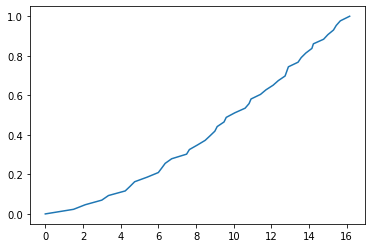

In [53]:
DataKNN = pd.read_csv('E6_KNN_T1_k4.csv')
# Find the unique values

# unique_values = np.sort(pd.Series)
# Make the rank array for these sorted and unique values in the dataset -
# ranks = np.arange(0,len(unique_values))/(len(unique_values)-1)
# Plot unique_values vs ranks

error = DataKNN['error']
## sort the unique values using pandas unique function
knn_error = np.sort(error.unique())
knn_cdf = np.arange(0,len(knn_error),step=1)/(len(knn_error)-1)

## plotting    
plt.plot(knn_error,knn_cdf)
plt.show()

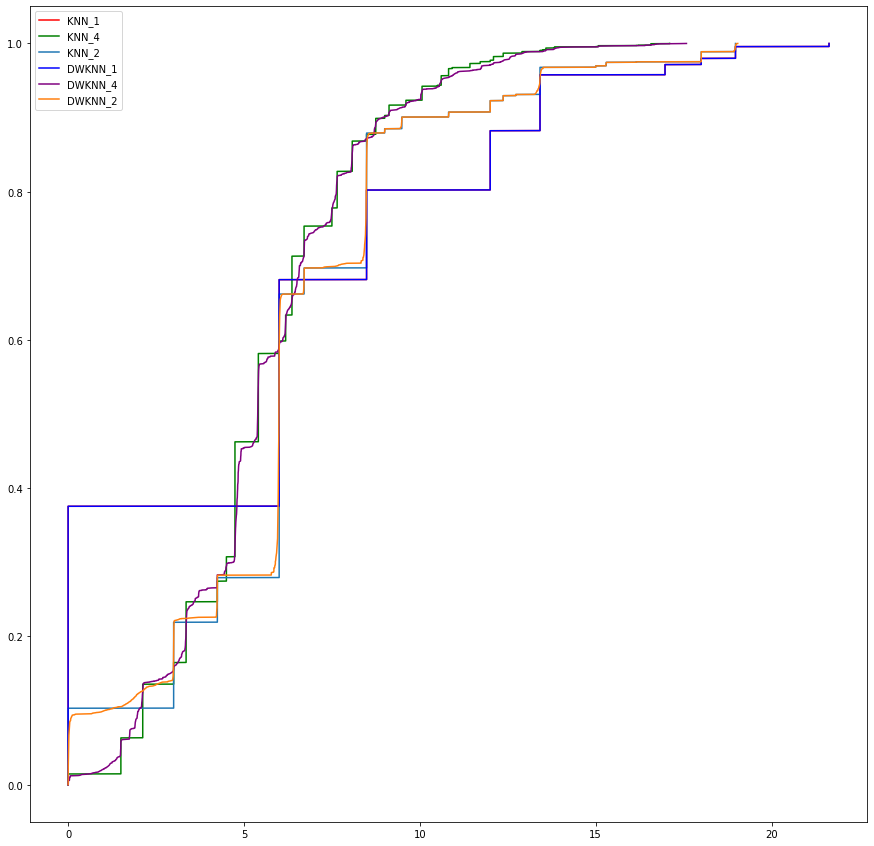

MEDIAN ERROR:
KNNcomp1      6.000000
KNNcomp2      6.000000
DWKNNcomp1    6.000000
DWKNNcomp2    5.994189
dtype: float64


In [23]:
fig= plt.figure(figsize=(15,15))
medErrorDf = pd.DataFrame(index = range(0,len(X_test)))

KNN_kcomp1 = pd.read_csv('E6_KNN_T1_k1.csv')
error = KNN_kcomp1['error']
medErrorDf['KNNcomp1'] = error
knn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp1_error),step=1)/(len(knn_kcomp1_error)-1)
## plotting    
plt.plot(knn_kcomp1_error,cdf, "red", label = "KNN_1")

KNN_kcomp2 = pd.read_csv('E6_KNN_T1_k4.csv')
error = KNN_kcomp2['error']
medErrorDf['KNNcomp2'] = error
knn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp2_error),step=1)/(len(knn_kcomp2_error)-1)
## plotting    
plt.plot(knn_kcomp2_error,cdf, "green", label = "KNN_4")

KNN_kcomp2 = pd.read_csv('E6_KNN_T1_k2.csv')
error = KNN_kcomp2['error']
medErrorDf['KNNcomp2'] = error
knn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp2_error),step=1)/(len(knn_kcomp2_error)-1)
## plotting    
plt.plot(knn_kcomp2_error,cdf, label = "KNN_2")

DWKNN_kcomp1 = pd.read_csv('E6_DWKNN_T1_k1.csv')
error = DWKNN_kcomp1['error']
medErrorDf['DWKNNcomp1'] = error
dwknn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp1_error),step=1)/(len(dwknn_kcomp1_error)-1)
## plotting    
plt.plot(dwknn_kcomp1_error,cdf, "blue", label = "DWKNN_1")

DWKNN_kcomp2 = pd.read_csv('E6_DWKNN_T1_k4.csv')
error = DWKNN_kcomp2['error']
medErrorDf['DWKNNcomp2'] = error
dwknn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp2_error),step=1)/(len(dwknn_kcomp2_error)-1)
## plotting
plt.plot(dwknn_kcomp2_error,cdf, "purple", label = "DWKNN_4")

DWKNN_kcomp2 = pd.read_csv('E6_DWKNN_T1_k2.csv')
error = DWKNN_kcomp2['error']
medErrorDf['DWKNNcomp2'] = error
dwknn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp2_error),step=1)/(len(dwknn_kcomp2_error)-1)
## plotting
plt.plot(dwknn_kcomp2_error,cdf, label = "DWKNN_2")

# additional plot params
plt.legend(loc='best', fontsize = 10)
plt.show()

print("MEDIAN ERROR:")
print(medErrorDf.median())